In [1]:
!ls data

olist_customers_dataset.csv           olist_orders_dataset.csv
olist_geolocation_dataset.csv         olist_products_dataset.csv
olist_order_items_dataset.csv         olist_sellers_dataset.csv
olist_order_payments_dataset.csv      product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
BASE_PATH = Path('../data')
from datetime import date, datetime
import os

**game plan**
- load order/ order_item / seller / product cat / review data
- extract RFM of sellers
- extract product categories distribution of sellers
- extract review of sellers

In [3]:
orders = pd.read_csv(BASE_PATH/'olist_orders_dataset.csv')
orders_item = pd.read_csv(BASE_PATH/'olist_order_items_dataset.csv')
sellers = pd.read_csv(BASE_PATH/'olist_sellers_dataset.csv')
products = pd.read_csv(BASE_PATH/'olist_products_dataset.csv')
product_cat_map = pd.read_csv(BASE_PATH/'product_category_name_translation.csv')
reviews = pd.read_csv(BASE_PATH/'olist_order_reviews_dataset.csv')

In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
orders_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [6]:
# merge orders and orders_item to get order date
print(orders_item.shape)
orders = orders_item.merge(orders, on='order_id')
print(orders.shape)

(112650, 7)
(112650, 14)


In [7]:
orders['order_status'].value_counts()

delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64

In [8]:
# filter only order status in ('delivered','shipped')
orders = orders[orders['order_status'].isin(['delivered','shipped'])]

## Create numerical features
- **Recency:** How far from the date of analysis that a seller got an order?
- **Age:** How long from the first order date til the ref date?
- **Total order:** Count of unique `order_id`
- **Frequency:** Mean order per month since first order | Total orders / Age
- **Period:** Mean days between orders | Age / Total orders
- **Monetary:** Average per order / Aggregated
- **Quantity:** Average per order / Aggregated
- **Unique categories:** Unique product catgories sold

In [9]:
# 1) Recency -> will use order_purchase_timestamp as a time dimension

# parse datetime
orders['order_purchase_timestamp'] = orders['order_purchase_timestamp'].apply(lambda x:pd.to_datetime(x).date())

In [10]:
orders['order_purchase_timestamp'].describe()

count         111382
unique           614
top       2017-11-24
freq            1359
Name: order_purchase_timestamp, dtype: object

In [11]:
# create reference date of analysis to be the next day of the last date in the data
ref_datetime = date(2018,9,4)

In [12]:
# calculate recency
orders['days_from_ref_date'] = orders['order_purchase_timestamp'].apply(lambda x: (ref_datetime - x).days)

recency = orders.groupby('seller_id')['days_from_ref_date'].min().reset_index()

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


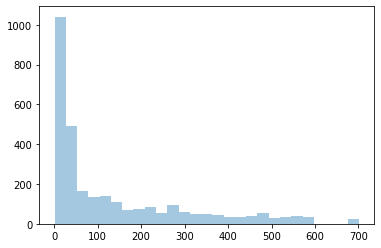

In [13]:
_ = sns.distplot(recency['days_from_ref_date'].values, kde=False)

In [14]:
orders.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date        2
order_delivered_customer_date    1193
order_estimated_delivery_date       0
days_from_ref_date                  0
dtype: int64

In [15]:
# 2) Age
age = orders.groupby('seller_id')['order_purchase_timestamp'].min().reset_index()
age['age'] = age['order_purchase_timestamp'].apply(lambda x:(ref_datetime - x).days)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


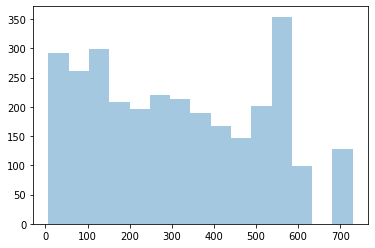

In [16]:
_ = sns.distplot(age['age'].values,kde=False)

In [17]:
# 3) Total order
total_order = orders.groupby('seller_id')['order_id'].nunique().reset_index()

total_order = total_order.rename({'order_id':'total_order'},axis=1)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


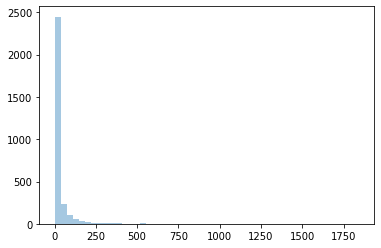

In [18]:
_ = sns.distplot(total_order['total_order'].values, kde=False)

In [19]:
total_order['total_order'].describe()

count    2977.000000
mean       33.230433
std       106.594751
min         1.000000
25%         2.000000
50%         7.000000
75%        22.000000
max      1844.000000
Name: total_order, dtype: float64

In [20]:
# 4) Frequency

# join total order and age
print(age.shape, total_order.shape)
freq = total_order.merge(age, on='seller_id')
print(freq.shape)

(2977, 3) (2977, 2)
(2977, 4)


In [21]:
# calculate frequency
freq['freq'] = freq['total_order'] / freq['age']

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


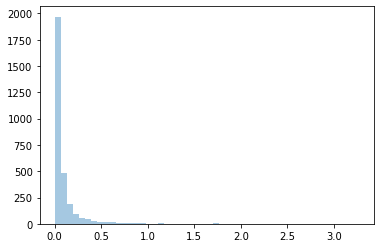

In [22]:
_ = sns.distplot(freq['freq'].values,kde=False)

In [23]:
freq['freq'].describe()

count    2977.000000
mean        0.098882
std         0.233867
min         0.001427
25%         0.012048
50%         0.036232
75%         0.093960
max         3.269504
Name: freq, dtype: float64

In [24]:
# 5) Period
freq['days_btw_order'] = freq['freq'].apply(lambda x: 1/x)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


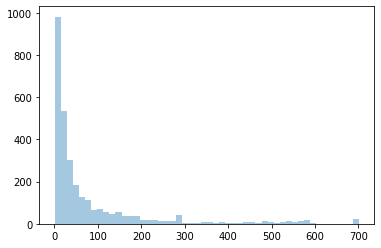

In [25]:
_ = sns.distplot(freq['days_btw_order'].values, kde=False)

In [37]:
# drop unused columns from freq
freq = freq.drop('order_purchase_timestamp',axis=1)

In [27]:
# 6) Monetary

# average per order
monetary_avg = orders.groupby(['seller_id','order_id'])['price'].sum().reset_index()\
    .groupby(['seller_id'])['price'].mean().reset_index().rename({'price':'monetary_avg'},axis=1)

monetary_sum = orders.groupby(['seller_id'])['price'].sum().reset_index().rename({'price':'monetary_sum'}, axis=1)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


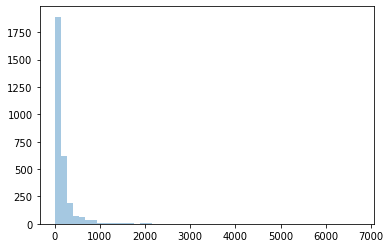

In [28]:
_ = sns.distplot(monetary_avg['monetary_avg'].values, kde=False)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


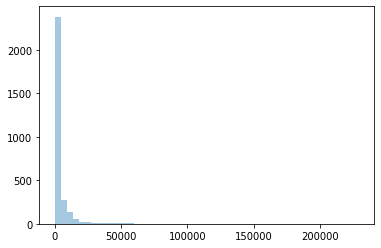

In [29]:
_ = sns.distplot(monetary_sum['monetary_sum'].values, kde=False)

In [30]:
# 7) Quantity

# average per order
quantity_avg = orders.groupby(['seller_id','order_id'])['order_item_id'].count().reset_index()\
    .groupby(['seller_id'])['order_item_id'].mean().reset_index().rename({'order_item_id':'quantity_avg'},axis=1)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


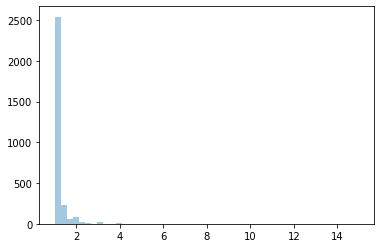

In [31]:
_ = sns.distplot(quantity_avg['quantity_avg'].values, kde=False)

In [32]:
# 8) unique categories

products = products.merge(product_cat_map, on='product_category_name',how='left')
products['product_category_name_english'] = products['product_category_name_english'].fillna('na')

orders = orders.merge(products, on='product_id')

cats = orders.groupby('seller_id')['product_category_name_english'].nunique().reset_index()\
    .rename({'product_category_name_english':'ncats'},axis=1)

In [40]:
# join everything
seller_feat = recency.merge(freq,on='seller_id')\
                .merge(monetary_avg, on='seller_id')\
                .merge(monetary_sum, on='seller_id')\
                .merge(quantity_avg, on='seller_id')\
                .merge(cats, on='seller_id')

In [42]:
out_dir = Path('output')
os.makedirs(out_dir,exist_ok=True)
seller_feat.to_csv(out_dir/'seller_feat.csv',index=False)